<Body>   
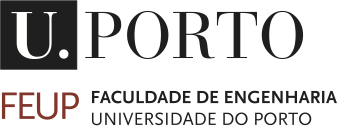   
<h1> <b>Swarm Robotics Competitions 2023/2024 </b> </h1>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt)

**José Pedro Carvalho** (jose.carvalho@fe.up.pt)

FEUP, Oct. 2023

---


# **Identification**

**Group:** 04

* **Name:** Lara Bastos **Student Number:** up202108740
* **Name:** Lia Sobral **Student Number:** up202108741
* **Name:** Miguel Barros **Student Number:** up202108678
* **Name:** Rita Pereira **Student Number:** up202108746



---





# Swarm Marathon Competition


**Goal:** Collect a set of resources at positions $R_i$, $i=1, \ldots M$, and drop them at the warehouse (green border in the plot) within a fixed period of time $T$.

**Specifications:**
-  The fleet is composed by 5 drones.
- Drone 1 is the leader and has access to its global position $x_1=[x_{1_1} x_{2_1}]$.
-  All the other drones *only* have access to the relative position $x_{ij}$ with respect to the other drones, if they are close enough to them (maximum range of MAX_RANGE).  
Example: Suppose that drone 1 and 3 are the only ones that are close to drone 2, then
drone 2 has access to the relative position $x_{21}=x_2-x_1$ and $x_{23}=x_2-x_3$, while the others by convention take the value zero $x_{24}=x_{25}=0$.
- All drones have access to the closest distance and angle (direction) of the nearest obstacle, that is, $d_{io}$ and $\theta_{io}$.
- The maximum linear velocities (input) in $x$ and $y$ directions is $1\,m/s$, that is, $-1\le u_x, u_y \le 1$.
- The resources can only be picked and transported with two drones. Moreover, when two drones are carrying a resource, they cannot carry a second resource, and they should be no more than MAX_R_DIS apart of each other, otherwise it is considered that the resource is lost.
- The drones cannot collide with each other, walls, and obstacles. In case of collision, the drone that collided stop and you do not have access to it. If it was transporting a resource, the resource returns to its initial position.

**Scores:**
- The times of picking the resources and dropping in the warehouse are saved. If the drones lost the resource, the time will be reseted.

- Wins the one that returned the maximum number of resources at the warehouse in less time.

**Parameters of this scenario:**
- Range of communication to obtain the relative position: MAX_RANGE = $5\,m$
- Maximum distance between 2 drones that they can be to pick a resource: MAX_R_PICK = $1\,m$
- Maximum distance between 2 drones that they can be to transport a resource: MAX_R_DIS = $3\,m$
- Initial configuration of the drones: 5-4-1-2-3 with same position in $y=-8\,m$ and in $x$ of $-2\,m, -1\,m, 0\,m, 1\,m, 2\,m$, respectively.
---

**Initial setup:** To download the file **aux_file.py**, run the next cell (only once).

In [ ]:
!git clone --depth 1 https://github.com/C2SR/CSR.git

Cloning into 'CSR'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 5), reused 7 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 1.43 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (5/5), done.




---
# **Scenario Task 0:** only one $R_1$ and no obstacles


### **Example: A swarm of 5 drones steering to resource $R_1$**


**Solution:** From the previous notebooks we see that one option to go to a desired point $x_d$ is to assign to drone 1 (leader) the feedback control law

$$
u_1 = - K_1 (x_1-x_d) + \frac{k_{o}(d_{1o})}{d_{1o}^2} ( x_1 - x_o ) + \dot{x}_d, \quad
k_{o}(d_{1o}) = \bar k_{1o}e^{-c d_{1o}^2},
$$

where
$K, k_{1o}, c$ are positive gains, $d_{1o}$ is the range to the nearest obstacle, $x_o$ is the center of the obstacle, and

$$
x_d = R_1, \quad \dot x_d = 0
$$


Note however that the above law cannot be implementable because we don't know $x_o$ !

But we can consider $x_o$ to be the closest point of the obstacle to the agent. In that case, we get $x_o= x_1+[d_{1o}\cos\theta_{1o}, d_{1o}\sin\theta_{1o}]^T$, and therefore, the control law simplifies to

$$
u_1 = - K_1 (x_1-x_d) - \frac{k_{o}(d_{1o})}{d_{1o}}
\left[
\begin{array}{c}
\cos\theta_{1o} \\
\sin\theta_{1o}
\end{array}
\right]
$$

where $d_{1o}$ and $\theta_{1o}$ is the range and angle of agent $1$ to the nearest obstacle.
There is still an issue... dividing by $d_{1o}$ could be a problem if it goes near zero... So one simple option is to make:

---
$$
u_1 = - K_1 (x_1-x_d) - \frac{k_{o}(d_{1o})}{(d_{1o}+\epsilon)}
\left[
\begin{array}{c}
\cos\theta_{1o} \\
\sin\theta_{1o}
\end{array}
\right]
$$

---
with $\epsilon>0$ a small constant.

To make sure that the other agents follow the leader, we set

---
$$
u_i = - K_i \sum_{j\in N_i}\big(x_{ij} -b_{ij}\big) + \sum_{j= 1}^n \frac{k_{o}(d_{ij})}{(d_{ij}^2+\epsilon)}  x_{ij} - \frac{k_{o}(d_{io})}{(d_{io}+\epsilon)}
\left[
\begin{array}{c}
\cos\theta_{io} \\
\sin\theta_{io}
\end{array}
\right], \quad i=2, 3,\ldots 5
$$

---
where $x_{ij}$ is the relative position from drone $i$ to drone $j$, and $d_{ij} = ||x_{ij}||$ its distance, $K$ is a $2\times 2$ positive-definite matrix gain, and the bias terms $b_{ij}= -b_{ji}$ specifies the formation configuration.


In [ ]:
Gnumber = 0  #Group number
%load CSR/csr_lib.py
from CSR.csr_lib import *
import numpy as np
import yaml


In [ ]:
###################################################################################################
##                                                                                               ##
##                                      Your code starts here                                    ##
##                                                                                               ##
###################################################################################################
# Here goes the list of variables that you can use in this part:
# Resource positions: R1, R2
# Boolean variables that indicate if the Resource is with a pair of drones: R1_caught, R2_caught
# Boolean variables that indicate if the Resource was delivered at the warehouse: R1_at_warehouse, R2_at_warehouse
# distances and angles to the nearest obstacle: d1o, angle1, d2o, angle2, ...
# position of drone 1: state1
# relative positions: x12, x13, x14, x15, x21, x23, x24, x25, ...
# note that the relative positions are set to zero when its norm is bigger than MAX_RANGE
def my_swarm_control_law(state_dict, angle, x):
    R1 = state_dict["Resource Position"][0]
    R1_caught = state_dict["Resource Caught"][0]
    R1_at_warehouse = state_dict["Resource Delivered"][0]
    do = state_dict["Distance to Obstacle"]
    state1 = state_dict["Leader State"]

    x21, x23, x24, x25 = x[1][0], x[1][2], x[1, 3], x[1, 4]
    x31, x32, x34, x35 = x[2][0], x[2][1], x[2, 3], x[2, 4]
    x41, x42, x43, x45 = x[3][0], x[3][1], x[3, 2], x[3, 4]
    x51, x52, x53, x54 = x[4][0], x[4][1], x[4, 2], x[4, 3]

    # My parameters
    kx, ky = 1, 1
    K1 = np.diag([kx, ky])
    kx, ky = 1, 1
    K2 = np.diag([kx, ky])
    K3 = np.diag([kx, ky])
    K4 = np.diag([kx, ky])
    K5 = np.diag([kx, ky])
    Ko_init = 1 * np.diag([1, 1])
    Kd_init = 2 * np.diag([1, 1])
    c = 5
    c1 = 5

    # Control law
    if R1_caught == False and R1_at_warehouse == False:
        # print("I'm steering to R1")
        #xd = R1
        xd= (R1[0], R1[1])
        b12 = [-0.2, 0.0]
        b23 = [-0.2, 0.0]
        b14 = [0.2, 0.0]
        b45 = [0.2, 0.0]

    if R1_caught :
        #print("I'm steering to the warehouse")
        #xd = R1
        #xd= (R1[0], R1[1])
        xd= (-7.5, -7.5)
        b12 = [-0.2, 0.0]
        b23 = [-0.2, 0.0]
        b14 = [0.2, 0.0]
        b45 = [0.2, 0.0]

    if R1_at_warehouse:
       xd= (-7.5, -7.5)
       b12 = [-0.2, 0.0]
       b23 = [-0.2, 0.0]
       b14 = [0.2, 0.0]
       b45 = [0.2, 0.0]

    # Drone 1 - Leader
    u_control1 = - K1 @ (state1 - xd) - (1 / (do[0] + .1)) * Ko_init * np.exp(-c * do[0] ** 2) @ (
        np.cos(angle[0]), np.sin(angle[0]))

    # Drone 2
    u_control2 = - K2 @ ((x21 + b12)) \
                 + 1 / (np.linalg.norm(x21) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x21) ** 2) @ x21 \
                 + 1 / (np.linalg.norm(x23) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x23) ** 2) @ x23 \
                 + 1 / (np.linalg.norm(x24) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x24) ** 2) @ x24 \
                 + 1 / (np.linalg.norm(x25) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x25) ** 2) @ x25 \
                 - 1 / (do[1] + .1) * Ko_init * np.exp(-c * do[1] ** 2) @ (np.cos(angle[1]), np.sin(angle[1]))

    # Drone 3
    # u_control3 = ...
    u_control3 = - K3 @ ((x32 + b23)) \
                 + 1 / (np.linalg.norm(x31) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x31) ** 2) @ x31 \
                 + 1 / (np.linalg.norm(x32) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x32) ** 2) @ x32 \
                 + 1 / (np.linalg.norm(x34) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x34) ** 2) @ x34 \
                 + 1 / (np.linalg.norm(x35) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x35) ** 2) @ x35 \
                 - 1 / (do[2] + .1) * Ko_init * np.exp(-c * do[2] ** 2) @ (np.cos(angle[2]), np.sin(angle[2]))

    # Drone 4
    # u_control4 = ...
    u_control4 = - K4 @ ( (x41+b14) ) \
                    + 1/(np.linalg.norm(x41)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x41)**2) @ x41 \
                    + 1/(np.linalg.norm(x42)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x42)**2) @ x42 \
                    + 1/(np.linalg.norm(x43)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x43)**2) @ x43 \
                    + 1/(np.linalg.norm(x45)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x45)**2) @ x45 \
                    - 1 / (do[3] + .1) * Ko_init * np.exp(-c * do[3] ** 2) @ (np.cos(angle[3]), np.sin(angle[3]))


  # Drone 5
  # u_control5 = ...
    u_control5 = - K5 @ ( (x54+b45) ) \
                    + 1/(np.linalg.norm(x51)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x51)**2) @ x51 \
                    + 1/(np.linalg.norm(x52)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x52)**2) @ x52 \
                    + 1/(np.linalg.norm(x53)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x53)**2) @ x53 \
                    + 1/(np.linalg.norm(x54)**2+.1)*Ko_init*np.exp(-c*np.linalg.norm(x54)**2) @ x54 \
                    - 1 / (do[4] + .1) * Ko_init * np.exp(-c * do[4] ** 2) @ (np.cos(angle[4]), np.sin(angle[4]))




 #  !! Delete these to be able to control the drones !!
 #   u_control1 = (0,0)
 #   u_control2 = (0,0)
 #   u_control3 = (0,0)
#    u_control4 = (0,0)
 #   u_control5 = (0,0)

    return u_control1, u_control2, u_control3, u_control4, u_control5





###################################################################################################
##                                                                                               ##
##                              End of your code section, do not edit the next part              ##
##                                                                                               ##
###################################################################################################

In [ ]:
with open('CSR/competition_task0/cfg/mission.yaml', 'r') as file:
    cfg_data = yaml.safe_load(file)
sim = Simulation(cfg_data)

for i in range(0, sim.t_signal.shape[0] - 1):

    if sim.t_signal[i] % 5 == 0:
        print("Time: t =", sim.t_signal[i])

    xij, ang = sim.get_relative_positions()
    u_control1, u_control2, u_control3, u_control4, u_control5 = my_swarm_control_law(sim.state_dict, ang, xij)
    u = [u_control1, u_control2, u_control3, u_control4, u_control5]
    sim.step(u)

Time: t = 0.0
Time: t = 5.0
Time: t = 10.0
Drone 1 found the Resource  1  at time t= 13.02
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.040000000000001
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.06
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.08
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.1
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.120000000000001
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.14
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.16
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.18
But no other drone found the Resource  1 ...
Drone 1 found the Resource  1  at time t= 13.200000000000001
But no other drone found the Resou

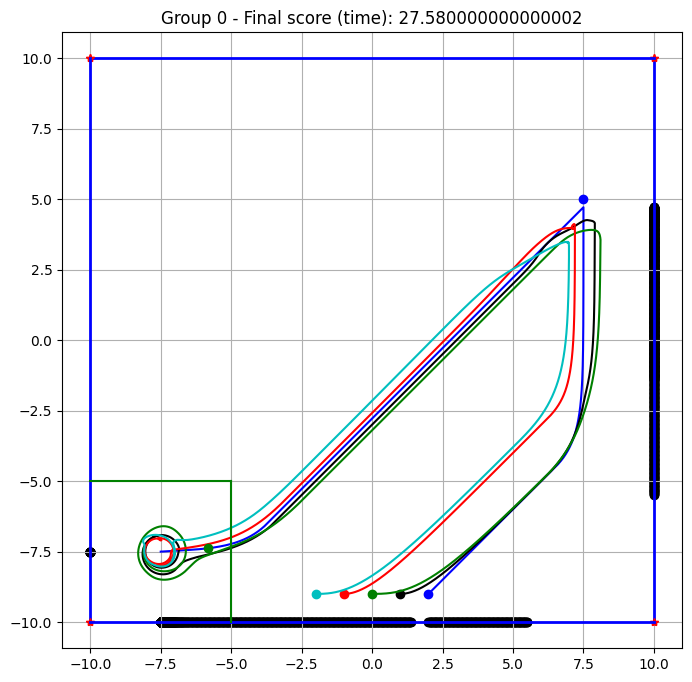

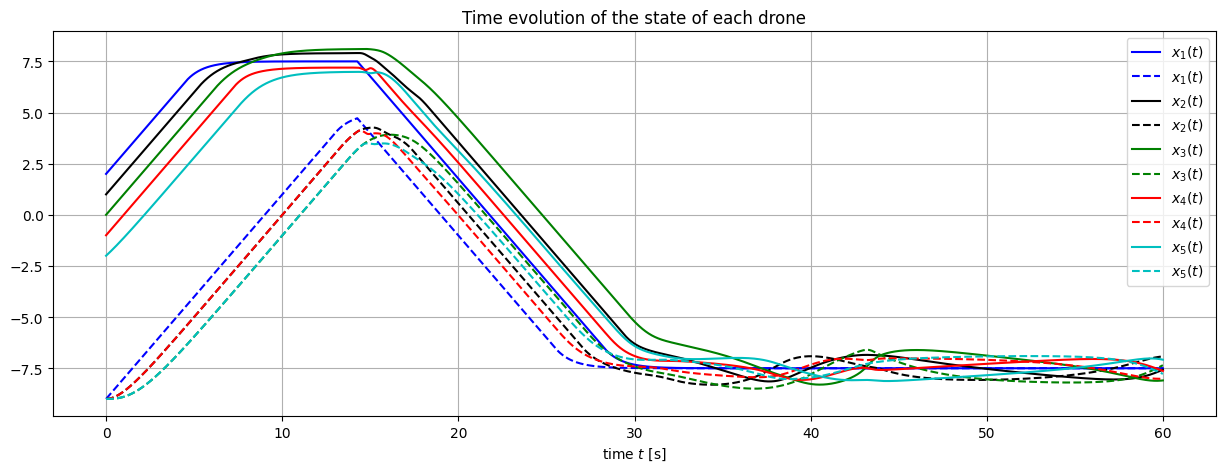

In [ ]:
# Plot commands
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18,18))
fig, ax = plt.subplots(figsize=(8, 8))

# plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim - 1, xdim + 1)
plt.ylim(-ydim - 1, ydim + 1)
plt.grid()

# Plots walls and obstacles
sim.world.plot()

pt1, = plt.plot([], [], 'b.', ms=20)
pt2, = plt.plot([], [], 'k.', ms=20)
pt3, = plt.plot([], [], 'g.', ms=20)
pt4, = plt.plot([], [], 'r.', ms=20)
pt5, = plt.plot([], [], 'c.', ms=20)
plt.plot(sim.x_signal[0, 0, 0], sim.x_signal[0, 1, 0], marker='o', color='b')
plt.plot(sim.x_signal[1, 0, 0], sim.x_signal[1, 1, 0], marker='o', color='k')
plt.plot(sim.x_signal[2, 0, 0], sim.x_signal[2, 1, 0], marker='o', color='g')
plt.plot(sim.x_signal[3, 0, 0], sim.x_signal[3, 1, 0], marker='o', color='r')
plt.plot(sim.x_signal[4, 0, 0], sim.x_signal[4, 1, 0], marker='o', color='c')

line1, = plt.plot(sim.x_signal[0, 0, :], sim.x_signal[0, 1, :], label='$x_1(t)$', color='b')
points_lidar = plt.scatter(sim.cpx[0], sim.cpy[0], label='$cpx_1(t)$', marker='o', color='k')
line2, = plt.plot(sim.x_signal[1, 0, :], sim.x_signal[1, 1, :], label='$x_2(t)$', color='k')
line3, = plt.plot(sim.x_signal[2, 0, :], sim.x_signal[2, 1, :], label='$x_3(t)$', color='g')
line4, = plt.plot(sim.x_signal[3, 0, :], sim.x_signal[3, 1, :], label='$x_4(t)$', color='r')
line5, = plt.plot(sim.x_signal[4, 0, :], sim.x_signal[4, 1, :], label='$x_5(t)$', color='c')
plt.plot((-10, -5), (-5, -5), color='g')
plt.plot((-5, -5), (-5, -10), color='g')

plt.title('Group ' + str(Gnumber) + ' - Final score (time): ' + str((sim.time_score[1])));

if sim.R_delivered[0] == False:
    initial_resource1, = plt.plot(sim.initial_resource[0][0], sim.initial_resource[0][1], marker='o', color='r')
else:
    initial_resource1, = plt.plot(sim.initial_resource[0][0], sim.initial_resource[0][1], marker='o', color='b')
    final_resource1, = plt.plot(sim.resource[0][0], sim.resource[0][1], marker='o', color='g')

if sim.num_R == 2:
    if sim.R_delivered[1] == False:
        initial_resource2, = plt.plot(sim.initial_resource[1][0], sim.initial_resource[1][1], marker='o', color='r')
    else:
        initial_resource2, = plt.plot(sim.initial_resource[1][0], sim.initial_resource[1][1], marker='o', color='b')
        final_resource2, = plt.plot(sim.resource[1][0], sim.resource[1][1], marker='o', color='g')

plt.figure(figsize=(15, 5))
plt.plot(sim.t_signal, sim.x_signal[0, 0, :], label='$x_1(t)$', color='b')
plt.plot(sim.t_signal, sim.x_signal[0, 1, :], label='$x_1(t)$', color='b', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[1, 0, :], label='$x_2(t)$', color='k')
plt.plot(sim.t_signal, sim.x_signal[1, 1, :], label='$x_2(t)$', color='k', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[2, 0, :], label='$x_3(t)$', color='g')
plt.plot(sim.t_signal, sim.x_signal[2, 1, :], label='$x_3(t)$', color='g', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[3, 0, :], label='$x_4(t)$', color='r')
plt.plot(sim.t_signal, sim.x_signal[3, 1, :], label='$x_4(t)$', color='r', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[4, 0, :], label='$x_5(t)$', color='c')
plt.plot(sim.t_signal, sim.x_signal[4, 1, :], label='$x_5(t)$', color='c', linestyle='dashed')
plt.xlabel('time $t$ [s]');
plt.legend(loc='best')
plt.grid()
plt.title('Time evolution of the state of each drone');





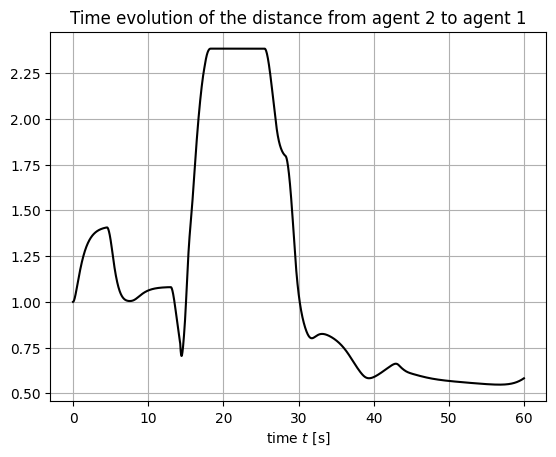

Results:
Time of picking Resource 1: 14.24
Time of delivering Resource 1 at the warehouse: 27.580000000000002
Final score: 27.580000000000002


In [ ]:
plt.figure()
x1 = sim.x_signal[0, 0, :]
y1 = sim.x_signal[0, 1, :]
x2 = sim.x_signal[1, 0, :]
y2 = sim.x_signal[1, 1, :]
x3 = sim.x_signal[2, 0, :]
y3 = sim.x_signal[2, 1, :]
x4 = sim.x_signal[3, 0, :]
y4 = sim.x_signal[3, 1, :]
x5 = sim.x_signal[4, 0, :]
y5 = sim.x_signal[4, 1, :]
xi21 = zip(x1, y1, x2, y2)
xi21 = [np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) for (x1, y1, x2, y2) in xi21]
plt.plot(sim.t_signal, xi21, label='$x_1-x_2$', color='k')
plt.grid()
plt.title('Time evolution of the distance from agent 2 to agent 1');
plt.xlabel('time $t$ [s]');
plt.show()

print("Results:")
# time_score: 0 - caught R_1, 1 - caught R_2, 2 - drop R_1 in warehouse, 3 - drop R_2 in warehouse
print('Time of picking Resource 1:', sim.time_score[0])
print('Time of delivering Resource 1 at the warehouse:', sim.time_score[1])
print('Final score:', sim.time_score[1])



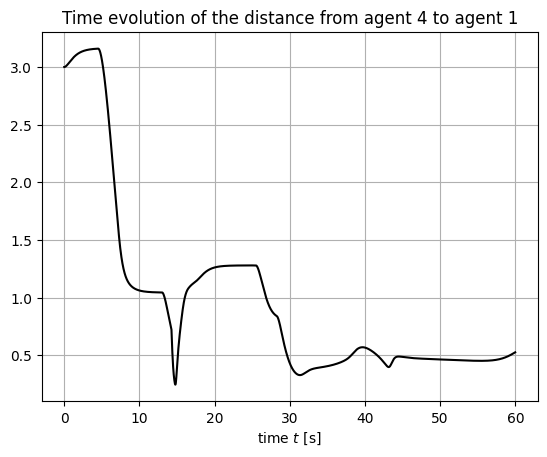

In [ ]:
plt.figure()


xi41=zip(x1,y1,x4,y4)
xi41 = [np.sqrt((x1-x4)**2+(y1-y4)**2) for (x1,y1,x4,y4) in xi41]
plt.plot(sim.t_signal, xi41, label='$x_1-x_4$', color='k')
plt.grid()
plt.title('Time evolution of the distance from agent 4 to agent 1');
plt.xlabel('time $t$ [s]');






In [ ]:
from matplotlib import animation

x1 = sim.x_signal[0, 0, :]
y1 = sim.x_signal[0, 1, :]
x2 = sim.x_signal[1, 0, :]
y2 = sim.x_signal[1, 1, :]
x3 = sim.x_signal[2, 0, :]
y3 = sim.x_signal[2, 1, :]
x4 = sim.x_signal[3, 0, :]
y4 = sim.x_signal[3, 1, :]
x5 = sim.x_signal[4, 0, :]
y5 = sim.x_signal[4, 1, :]


fnum = len(x1)



def drawframe(n):
    size_x = len(x1)
    frames = 100
    t_win = int(size_x / frames * (n + 1) - 1)
    if sim.time_score[1] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[0]:
            initial_resource1.set_data(sim.initial_resource[0][0], sim.initial_resource[0][1])
            initial_resource1.set_color('r')
        else:
            initial_resource1.set_color('b')

    if sim.time_score[1] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[1]:
            final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
            final_resource1.set_color("w")
            final_resource1.set_alpha(0.0)
        else:
            final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
            final_resource1.set_color("g")
            final_resource1.set_alpha(1.0)



    pt1.set_data(sim.x_signal[0,0, t_win], sim.x_signal[0,1, t_win])
    pt2.set_data(sim.x_signal[1,0, t_win], sim.x_signal[1,1, t_win])
    pt3.set_data(sim.x_signal[2,0, t_win], sim.x_signal[2,1, t_win])
    pt4.set_data(sim.x_signal[3,0, t_win], sim.x_signal[3,1, t_win])
    pt5.set_data(sim.x_signal[4,0, t_win], sim.x_signal[4,1, t_win])

    line1.set_data(x1[0:t_win], y1[0:t_win])
    line2.set_data(x2[0:t_win], y2[0:t_win])
    line3.set_data(x3[0:t_win], y3[0:t_win])
    line4.set_data(x4[0:t_win], y4[0:t_win])
    line5.set_data(x5[0:t_win], y5[0:t_win])
    #points_lidar.set_offsets(np.c_[sim.cpx[0,0:t_win], sim.cpy[0,0:t_win]])
    return (line1, line2)


# blit=True re-draws only the parts that have changed.
# anim = animation.FuncAnimation(fig, drawframe, frames=fnum, interval=1000, blit=True)
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=50, blit=True)

from IPython.display import HTML

HTML(anim.to_html5_video())


<ipython-input-10-de23897ead08>:25: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  initial_resource1.set_data(sim.initial_resource[0][0], sim.initial_resource[0][1])
<ipython-input-10-de23897ead08>:32: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
<ipython-input-10-de23897ead08>:42: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pt1.set_data(sim.x_signal[0,0, t_win], sim.x_signal[0,1, t_win])
<ipython-input-10-de23897ead08>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pt2.set_data(sim.x_signal[1,0, t_win], sim.x_signal[1,1, t_win])
<ipython-input-10-de23897e